# Test MuJoCo implementation and rendering

In [1]:
import mujoco
import mujoco.viewer
from nav2d import Nav2D
import numpy as np
import os
import matplotlib.pyplot as plt


model_json_path = os.path.join(os.getcwd(),"environment_params.json")
test_env = Nav2D(json_file= model_json_path)
model, data = test_env.model, test_env.data

vel_hist = []
avel_hist = []
angle_hist = []

Visualize the rendering using mujoco.viewer passive launch

In [2]:
with mujoco.viewer.launch_passive(model, data) as viewer:
	i = 0
	
	# # Select the camera
	CAMERA_NAME = "overhead_camera"
	viewer.cam.type = mujoco.mjtCamera.mjCAMERA_FIXED
	viewer.cam.fixedcamid = model.camera(CAMERA_NAME).id

	# enable viewer options:
	viewer.opt.frame = mujoco.mjtFrame.mjFRAME_BODY
	viewer.opt.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True
	term = False

	while viewer.is_running():
		i+=1
		
		# --- control simulation
		ctrl = np.zeros(3)
		ctrl[0] = 0.01 if not term else 0
		ctrl[2] = 0.0005 if not term else 0

		# --- simulation
		nobs, rew, term, trunc, _ = test_env.step(ctrl)
		# print(test_env.data.qvel)
		viewer.sync()
		
		if (i % 1000 == 0):
			# print(nobs[2])
			# agent_pose, goal_pose, lidar_obs = test_env._get_obs()
			# pos = test_env._get_obs()
			# print(rew, min(lidar_obs))
			# print(agent_pose[0:3], goal_pose)

			# ============= agent control debug =============
			# print(agent_pose)
			# x, y, theta, x_dot, y_dot, theta_dot = agent_pose
			# print(f"theta_{i:7d}: {agent_pose[2]/np.pi*180:6.3f} deg | theta_dot_{i:7d}: {agent_pose[5]/np.pi*180:6.2f} deg/s", end="\r")
			# print(f"Time {i:10d} - Robot position ({x:5.3f},{y:5.3f}) | Goal position {goal_pose}")
			# lin_vel = np.sqrt(x_dot**2 + y_dot**2)

			# angle_hist.append(theta)
			# vel_hist.append(lin_vel)
			# avel_hist.append(theta_dot)
			# print(f"Current robot linear velocities at time {i:7d}: {lin_vel:10.5}", end="\r")

			# ============= goal pose debug =============
			# print(goal_pose)

			# ============= LIDAR obs debug =============
			# print(lidar_obs)

			# ============= termination debug =============
			if term:
				print(f"Termination condition reached at {i}")
				obs, _ = test_env.reset(agent_randomize = True, 
										goal_randomize = True, 
										obstacle_randomize = False)
				# # pause the viewer
				# while viewer.is_running():
				# 	viewer.sync()
				# break

Termination condition reached at 43000
Termination condition reached at 55000
Termination condition reached at 62000
Termination condition reached at 74000
Termination condition reached at 80000
Termination condition reached at 110000
Termination condition reached at 118000
Termination condition reached at 136000
Termination condition reached at 177000
Termination condition reached at 242000
Termination condition reached at 314000
Termination condition reached at 321000
Termination condition reached at 365000


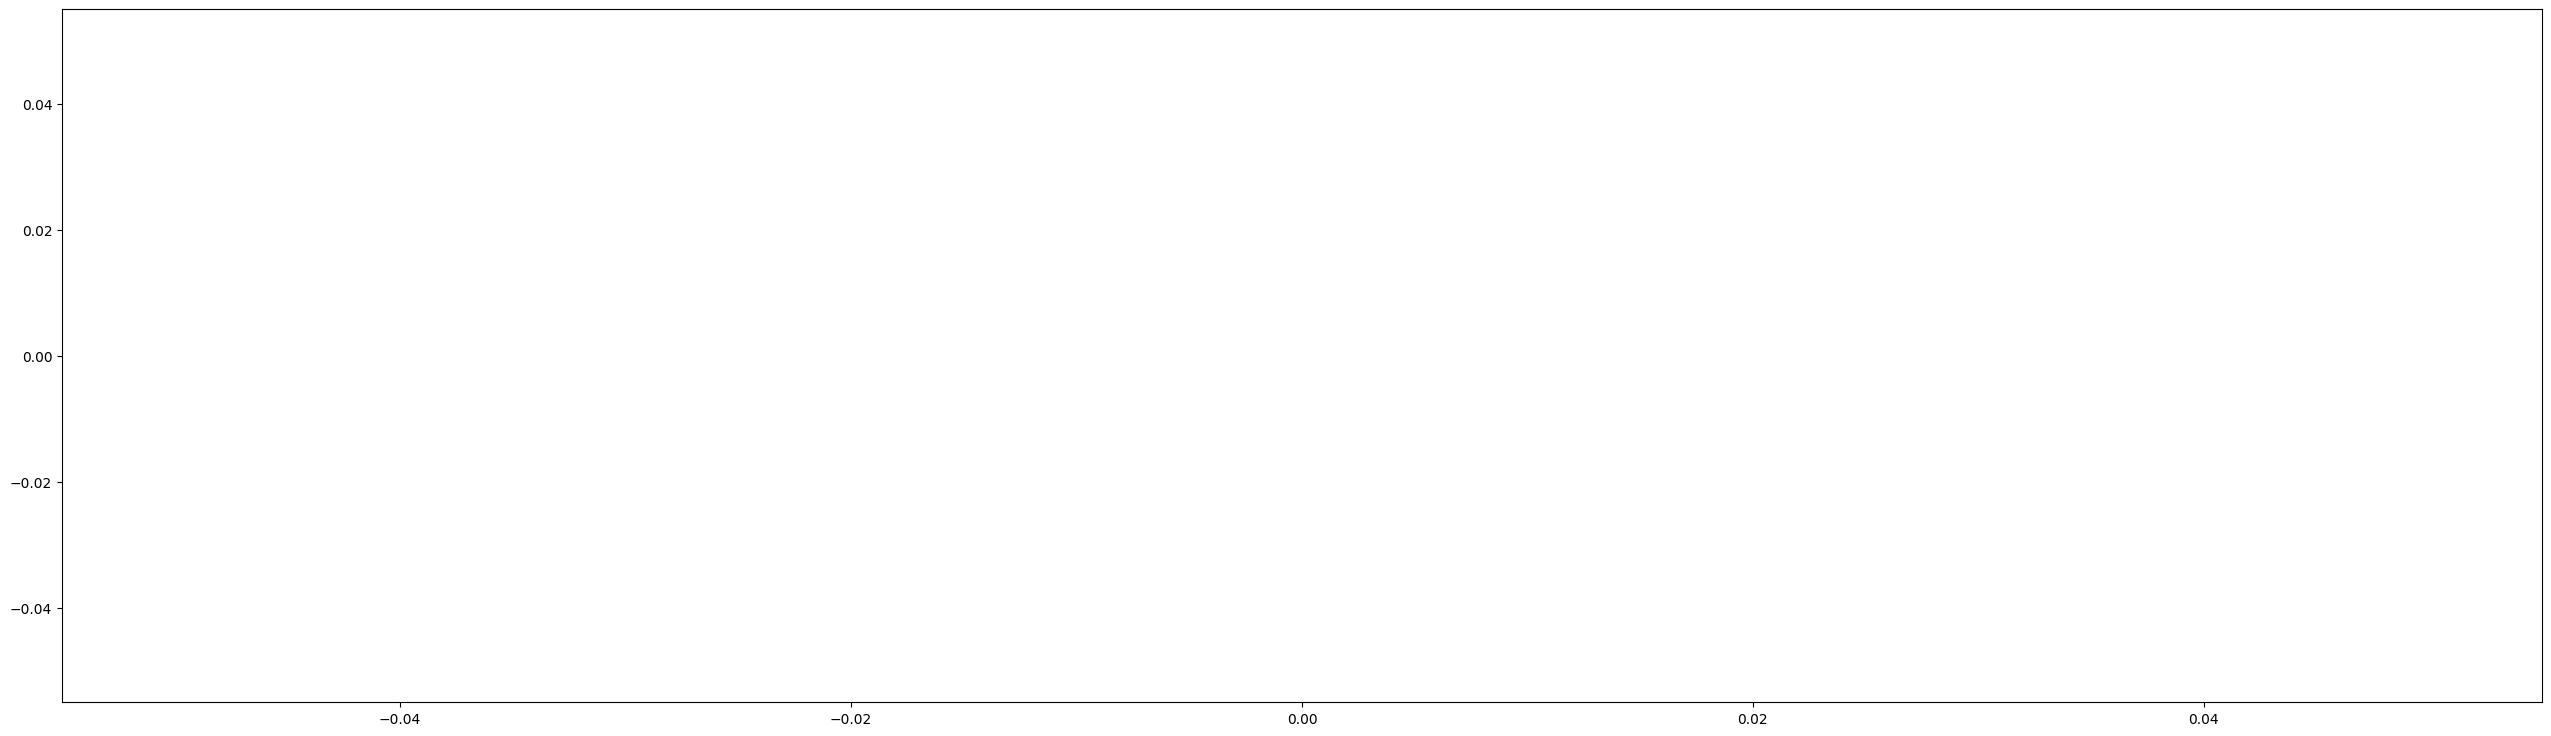

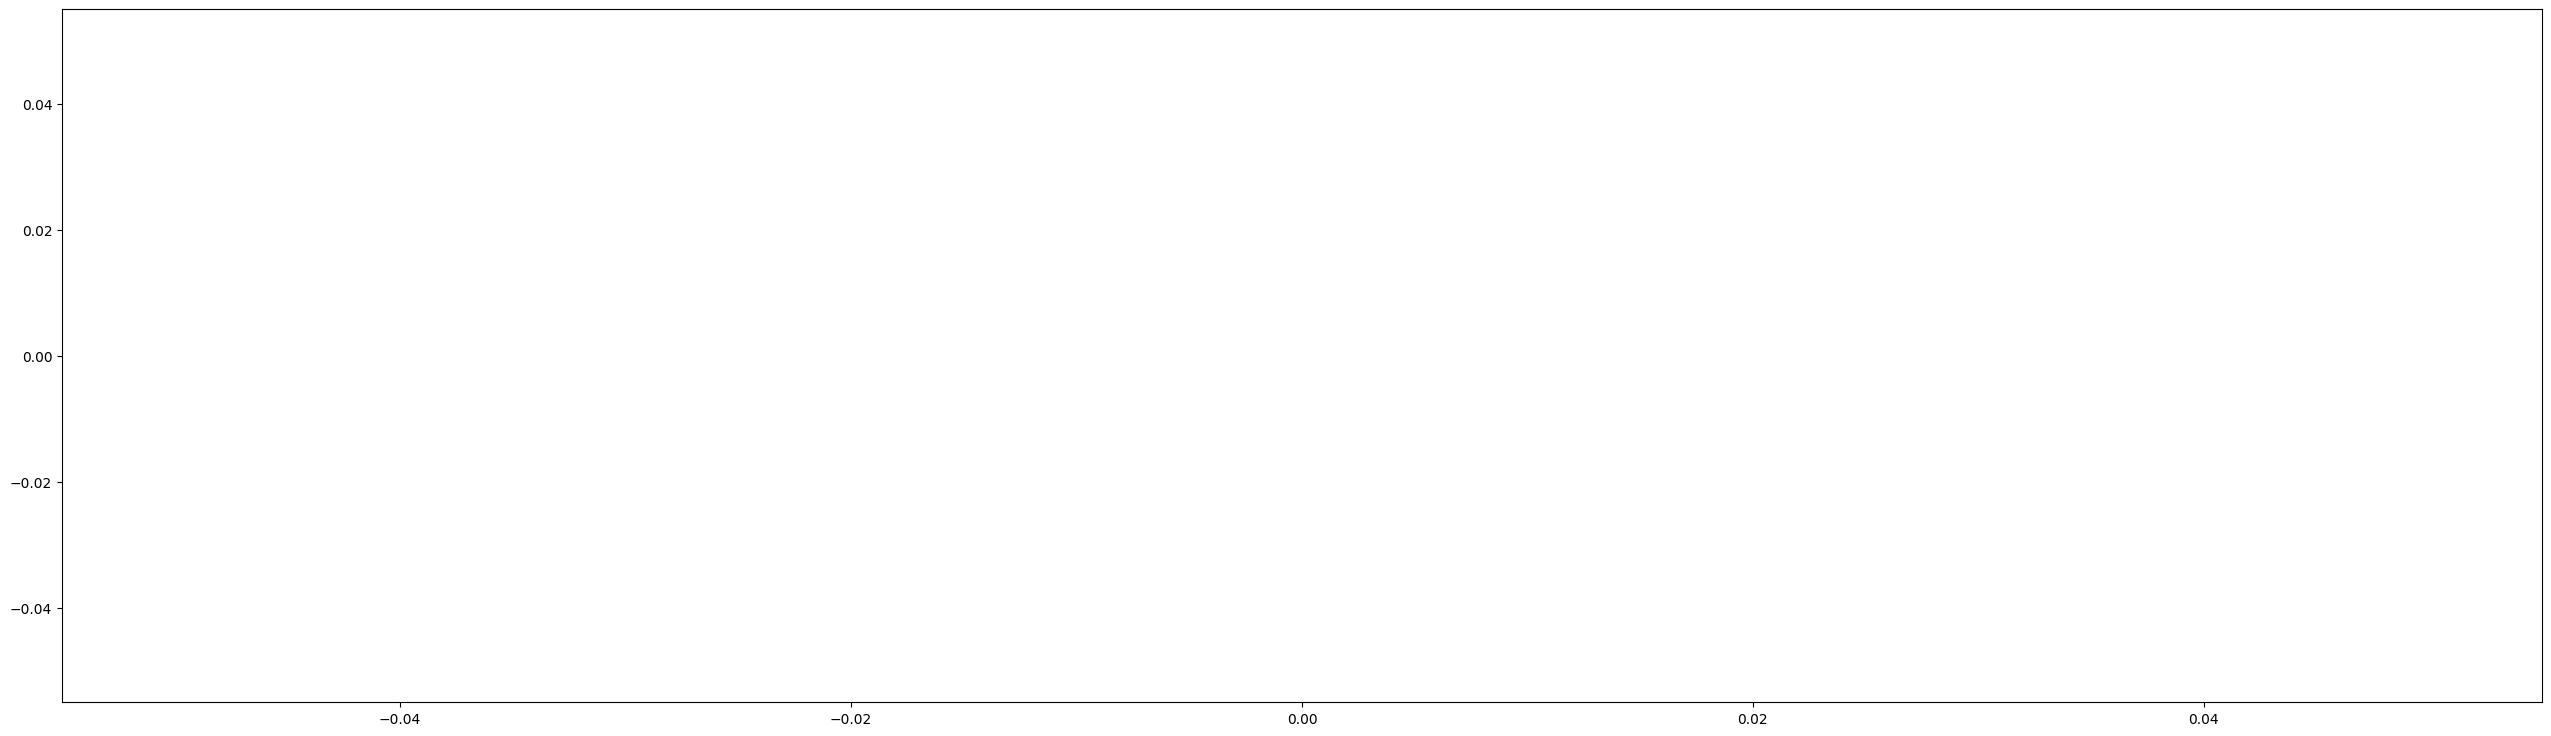

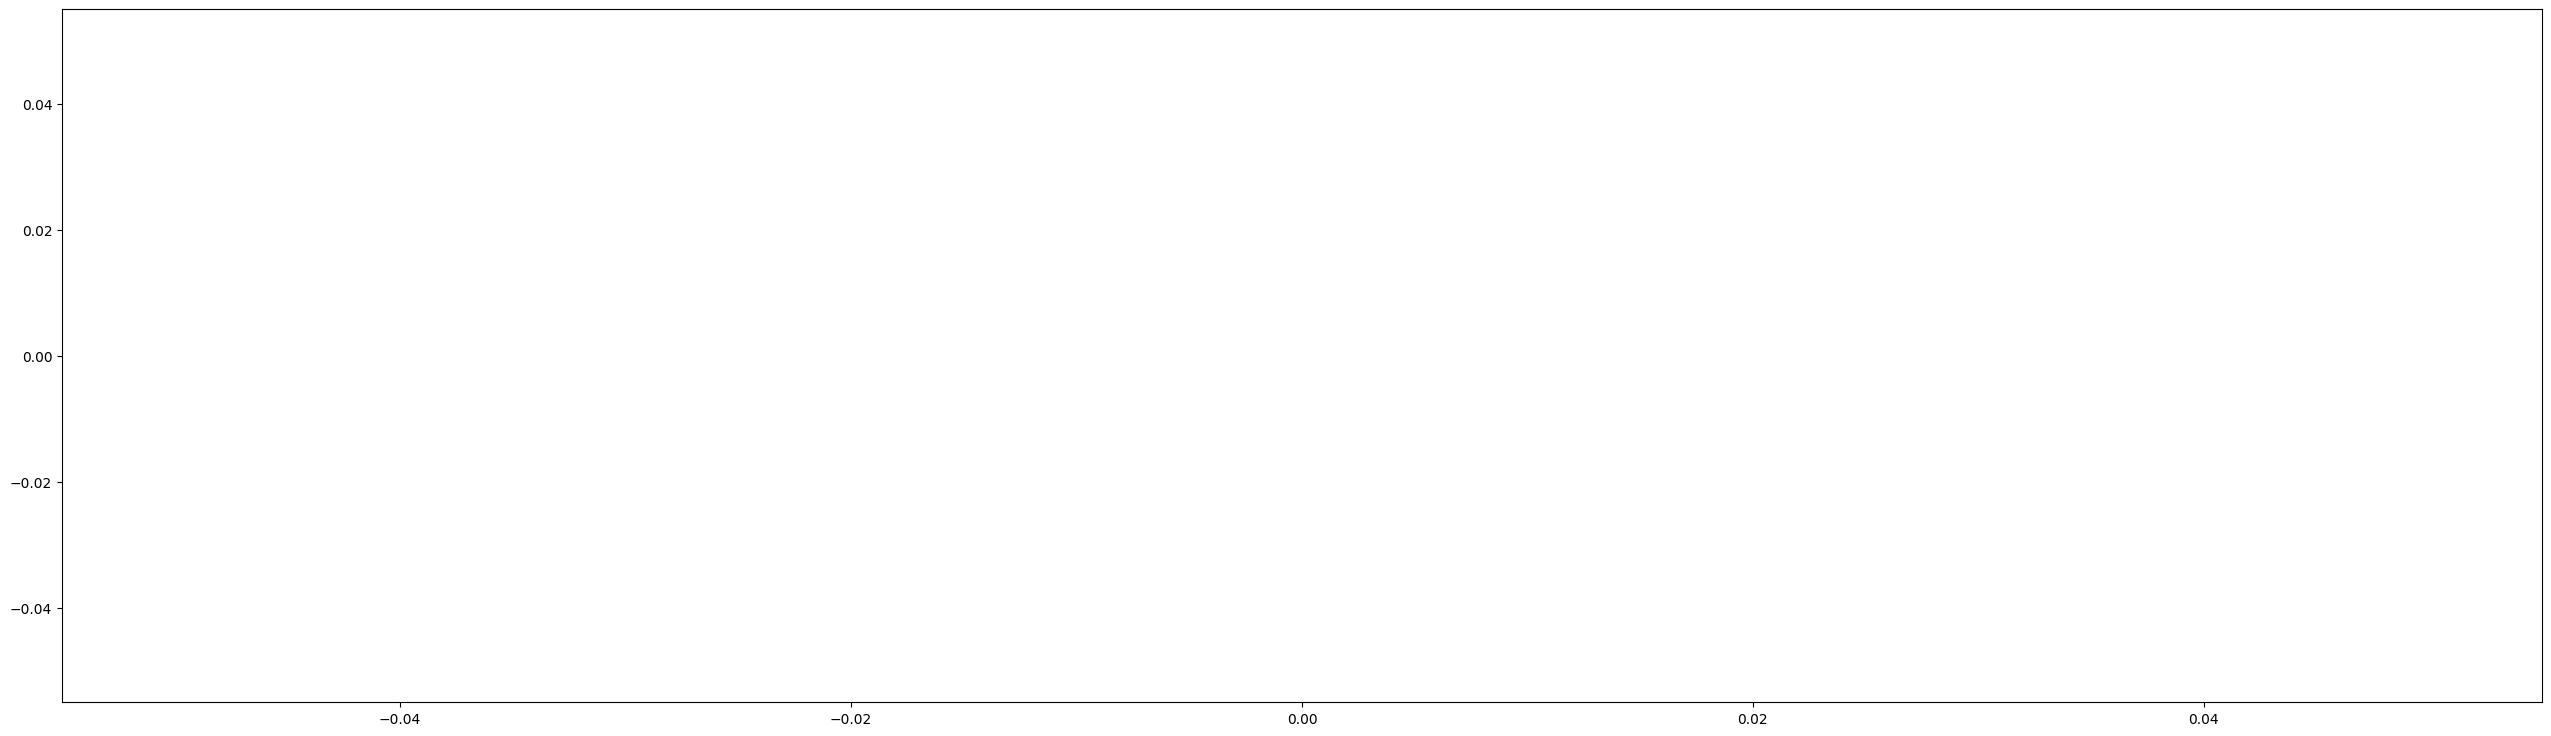

In [3]:
figure = plt.figure(figsize=(32,9))
plt.plot(vel_hist)

figure = plt.figure(figsize=(32,9))
plt.plot(avel_hist)

# figure = plt.figure(figsize=(32,9))
# ctrl_x, ctrl_y, ctrl_z = zip(*ctrl_hist)
# linear_ctrl_norm = np.sqrt(np.square(ctrl_x) + np.square(ctrl_y))
# plt.plot(np.round(linear_ctrl_norm,4))

figure = plt.figure(figsize=(32,9))
plt.plot(angle_hist)

In [5]:
theta_range = np.linspace(0, 2*np.pi, num=100)
action = np.array([0.05, 0, 0], dtype=np.float32)
action_mag_hist = np.zeros(len(theta_range))

for idx, theta in enumerate(theta_range):
    rot_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                        [np.sin(theta), np.cos(theta)]], dtype=np.float32)
    action_transformed = action
    action_transformed[:2] = rot_matrix @ action[:2]
    # print(action_transformed)
    action_mag_hist[idx] = np.linalg.norm(action_transformed[:2])

action_mag_hist

array([0.05      , 0.05      , 0.05      , 0.05      , 0.05      ,
       0.05      , 0.05      , 0.05      , 0.05      , 0.05      ,
       0.05      , 0.05      , 0.05      , 0.05      , 0.05      ,
       0.05      , 0.05      , 0.05000001, 0.05      , 0.05      ,
       0.05      , 0.05000001, 0.05000001, 0.05000001, 0.05000001,
       0.05000001, 0.05000001, 0.05      , 0.05      , 0.05      ,
       0.05      , 0.05      , 0.05000001, 0.05      , 0.05      ,
       0.05000001, 0.05      , 0.05      , 0.05000001, 0.05000001,
       0.05000001, 0.05000001, 0.05000001, 0.05000001, 0.05000001,
       0.05000001, 0.05000001, 0.05000001, 0.05000001, 0.05      ,
       0.05      , 0.05      , 0.05      , 0.05      , 0.05      ,
       0.05      , 0.05      , 0.05      , 0.05      , 0.05      ,
       0.05      , 0.05      , 0.05      , 0.05000001, 0.05      ,
       0.05      , 0.05      , 0.05      , 0.05      , 0.05      ,
       0.05      , 0.05      , 0.05      , 0.05      , 0.05   

# Test gymnasium implementation & rendering

In [ ]:
import mujoco as mj
import gymnasium as gym
import nav2d
import pyautogui

width = 1920
height = 1080
default_camera_config = {"azimuth" : 90, "elevation" : -90.0, "distance" : 3, "lookat" : [0.0, 0.0, 0.0]}

# Reference for setting visual flags https://mujoco.readthedocs.io/en/stable/APIreference/APItypes.html#mjtvisflag
visual_options = {2: True, 8: True}      # e.g., visualize the joints by setting mjVIS_JOINT (index 2) = True

# There are a few visualization things that cannot be set when making the env
# Ref - https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/mujoco/mujoco_rendering.py
# They can only be changed via keypresses in the gymnasium mujoco rendering. 
# Here are some flags to specify what key to press. The key presses are simulated using `pyautogui`
# (Super rough appproach but oh well)
DEFAULT_CAMERA = "overhead_camera"
ENABLE_FRAME = True                     # enable the body frames
RENDER_EVERY_FRAME = False              # similar sim speed as MuJoCo rendering when set to False, else slower

env = gym.make("Nav2D-v0", 
               render_mode="human", 
               width=width, height=height,
               default_camera_config=default_camera_config,
               visual_options=visual_options
               )
obs, info = env.reset()

# Simulate keypress for visualization elements in gymnasium MuJoCo rendering
if DEFAULT_CAMERA=="overhead_camera": pyautogui.press('tab')
if ENABLE_FRAME: pyautogui.press('e') 
if not RENDER_EVERY_FRAME: pyautogui.press('d') 

for i in range(5):
    done = False
    # enable the body frame by simulating a keypress once lmao
    
    while not done:
        action = [0.5, 0, 0.5]
        nobs, rew, term, trunc, info = env.step(action)
        
        done = term or trunc
        obs = nobs if not done else env.reset()[0]
        # if done: print(nobs, info)

env.close()